$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[]{\,\middle\vert\,}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\newcommand{\grad}[]{\nabla}
$$

# Part 4: Mini-Project
<a id=part3></a>

In this part you'll implement a small comparative-analysis project, heavily based on the materials from the tutorials and homework.

In [ ]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Guidelines

- You should implement the code which displays your results in this notebook, and add any additional code files for your implementation in the `project/` directory. You can import these files here, as we do for the homeworks.
- Running this notebook should not perform any training - load your results from some output files and display them here. The notebook must be runnable from start to end without errors.
- You must include a detailed write-up (in the notebook) of what you implemented and how. 
- Explain the structure of your code and how to run it to reproduce your results.
- Explicitly state any external code you used, including built-in pytorch models and code from the course tutorials/homework.
- Analyze your numerical results, explaining **why** you got these results (not just specifying the results).
- Where relevant, place all results in a table or display them using a graph.
- Before submitting, make sure all files which are required to run this notebook are included in the generated submission zip.
- Try to keep the submission file size under 10MB. Do not include model checkpoint files, dataset files, or any other non-essentials files. Instead include your results as images/text files/pickles/etc, and load them for display in this notebook. 

## Spectrally-Normalized Wasserstein GANs

One of the prevailing approaches for improving training stability for GANs is to use a technique called [Spectral Normalization](https://arxiv.org/pdf/1802.05957.pdf) to normalize the largest singular value of a weight matrix so that it equals 1.
This approach is generally applied to the discriminator's weights in order to stabilize training. The resulting model is sometimes referred to as a SN-GAN.
See Appendix A in the linked paper for the exact algorithm. You can also use pytorch's `spectral_norm`.

Another very common improvement to the vanilla GAN is known a [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf) (WGAN). It uses a simple modification to the loss function, with strong theoretical justifications based on the Wasserstein (earth-mover's) distance.
See the tutorial or [here](https://developers.google.com/machine-learning/gan/loss) for a brief explanation of this loss function.

One problem with generative models for images is that it's difficult to objectively assess the quality of the resulting images.
To also obtain a quantitative score for the images generated by each model,
we'll use the [Inception Score](https://arxiv.org/pdf/1606.03498.pdf).
This uses a pre-trained Inception CNN model on the generated images and computes a score based on the predicted probability for each class.
Although not a perfect proxy for subjective quality, it's commonly used a way to compare generative models.
You can use an implementation of this score that you find online, e.g. [this one](https://github.com/sbarratt/inception-score-pytorch) or implement it yourself.

You would gain a **Bonus** if you also adress [Gradient Penalty](https://arxiv.org/pdf/1704.00028.pdf), as we saw in the tutorial that it could improve the robustness of the GAN and essentially improve the results


Based on the linked papers, add Spectral Normalization and the Wassertein loss to your GAN from HW3.
Compare between:
- The baseline model (vanilla GAN)
- SN-GAN (vanilla + Spectral Normalization)
- WGAN (using Wasserstein Loss)
- Optional: SN+WGAN, i.e. a combined model using both modifications.
- Bonus: WGAN+GP and SN+WGAN+GP

As a dataset, you can use [LFW](http://vis-www.cs.umass.edu/lfw/) as in HW3 or [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), or even choose a custom dataset (note that there's a dataloder for CelebA in `torchvision`). 

Your results should include:
- Everything written in the **Guidelines** above.
- A comparative analysis between the baseline and the other models. Compare:
  - Subjective quality (show multiple generated images from each model)
  - Inception score (can use a subset of the data).
- You should show substantially improved subjective visual results with these techniques.

## Implementation

**TODO**: This is where you should write your explanations and implement the code to display the results.
See guidelines about what to include in this section.

In [ ]:
from project.gan import *
from project.hyperparams import *
from project.train import *
from project.data_loader import *

### Creating dataset
We will use the GW Bush Dataset

The code used to import and read data is taken from previous sections

In [ ]:
dl_train = BushDataLoader(50, shuffle=True)

Saved to /root/.pytorch-datasets/lfw-bush.zip.
Extracting /root/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /root/.pytorch-datasets/lfw/George_W_Bush


Found 530 images in dataset folder.


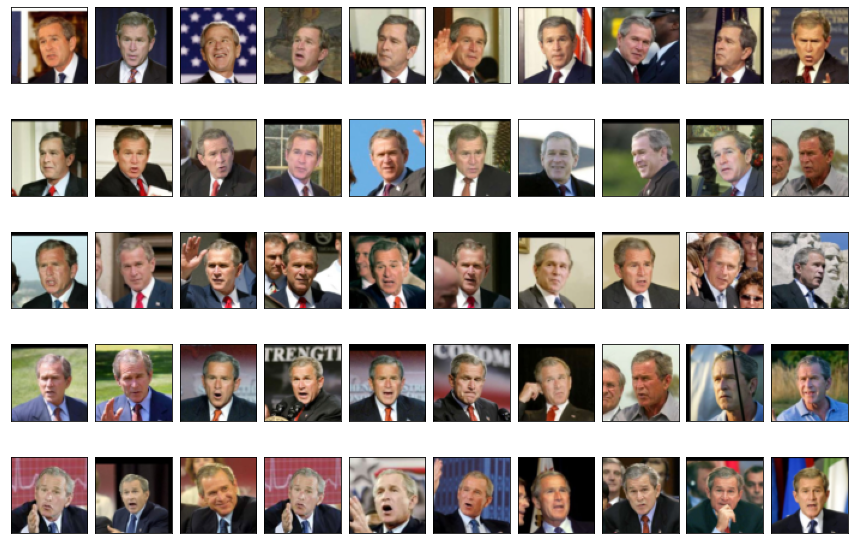

In [ ]:
#plotting samples of images
_ = plot.dataset_first_n(dl_train.ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(dl_train.ds_gwb)} images in dataset folder.')

### Creating Models

The following models were implemented on the GW Bush dataset:

*   The baseline model (vanilla GAN)
*   SN-GAN (vanilla + Spectral Normalization)
*   WGAN (using Wasserstein Loss)
*   SN+WGAN

In [ ]:
# import pandas as pd
results = pd.DataFrame(columns = ['Model', 'Inception Score'])

#### Vanilla GAN - Baseline Model

*   **Generator** is composed of 5 transposed convolutional layers. After the first 4 layers there is a batch norm and ReLU activation. After the last transposed convolution there is a TanH activation function. 
*   **Discriminator** is composed of 4 convolusional layers, each followed by a batch norm then LeakyReLU layer. This is followed by a final convolution layer and then a sigmoid activation.
*   Both discriminator and generator used Adam optimizer

##### Training

In [1]:
#Vanilla training
hp = vanilla_gan_hyperparams()
print(hp)
gan = GANTrainer(hp, dl_train).train(200)
results = results.append(pd.DataFrame([['GAN', gan]], columns=['Model', 'Inception Score']))

##### Results

In [ ]:
print(f'''Inception score for final GAN model: 1.4 \n
Best hyperparameters: 
Batch size: {vanilla_gan_hyperparams()['batch_size']}
z_dim: {vanilla_gan_hyperparams()['z_dim']}
Discriminator optimizer learning rate: {vanilla_gan_hyperparams()['discriminator_optimizer']['lr']}
Discriminator optimizer betas: {vanilla_gan_hyperparams()['discriminator_optimizer']['betas']}
Generator optimizer learning rate: {vanilla_gan_hyperparams()['generator_optimizer']['lr']}
Generator optimizer betas: {vanilla_gan_hyperparams()['generator_optimizer']['betas']}
 ''')

Inception score for final GAN model: 1.4 

Best hyperparameters: 
Batch size: 36
z_dim: 10
Discriminator optimizer learning rate: 0.0002
Discriminator optimizer betas: (0.3, 0.999)
Generator optimizer learning rate: 0.0002
Generator optimizer betas: (0.1, 0.999)
 


*** Images Generated from best model:


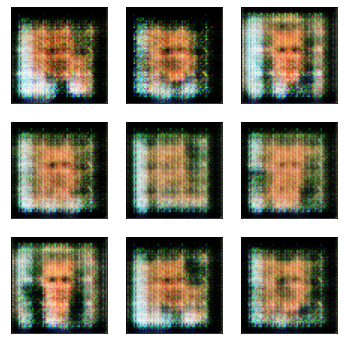

In [ ]:
checkpoint_file = 'checkpoints/gan_final_part4.pt'
if os.path.isfile(checkpoint_file):
    gen = torch.load(f'{checkpoint_file}', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=9, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

**Observations**:

The inner image looks very blury, but there is still some resemblance to a while male. The eye regions are not well defined, but since the coloring of the eyes is contrasted with the coloring of the rest of the face, the model is able to properly locate the positioning of the eyes. Other facial features that are more similar in color like nose and mouth are less discerning. Seems like the vanilla GAN, does a decent job at generating distinguishing features on a face when they can be distinguised by a change in shape and color. However, its hard to say that these generated images look specifically like George W. Bush's face compared to any other while male's face. 

The model, is not able to well define the background of the image. Even more so, it does not know how to generate any pixels next to the border on all sides. We are not sure why this is so. 

Another finding that was noticed in these generated samples is that the better images seem to be facing right. This is noticed by the positioning of the eyes. It could be that the model was trained on more right facing images. Another hypothesis, is that the filters in the network were  better fit for facial finding on a right facing face. 

In the beginning on the training, the discriminator loss was around 1 and generator loss around 0.7. As more epochs were run and the generated image improved, the discriminator loss actually increased to around 1.6 and the generator loss decreased to 0.3. This was expected since we are at the same time optimizing 2 different conflicitng losses. As one goes down the other must go up, and there is a trade off between the 2 values.  

#### WGAN


*   The discriminator and generator used here are the same networks as in the vanilla GAN. The difference in this model is the loss function. Wasserstein loss function was used here. 
*   RMSprop optimizers were used for discriminator and generator




##### Training

In [2]:
#WGAN
hp = wgan_hyperparams()
print(hp)
wgan_inc_score = WGANTrainer(hp, dl_train).train(200)
results = results.append(pd.DataFrame([['WGAN', wgan_inc_score]], columns=['Model', 'Inception Score']))

##### Results

In [ ]:
print(f'''Inception score for final GAN model: 3.4 \n
Best hyperparameters: 
Batch size: {wgan_hyperparams()['batch_size']}
z_dim: {wgan_hyperparams()['z_dim']}
Discriminator optimizer learning rate: {wgan_hyperparams()['discriminator_optimizer']['lr']}
Generator optimizer learning rate: {wgan_hyperparams()['generator_optimizer']['lr']}
 ''')

Inception score for final GAN model: 3.4 

Best hyperparameters: 
Batch size: 36
z_dim: 16
Discriminator optimizer learning rate: 0.0005
Generator optimizer learning rate: 0.0005
 


*** Images Generated from best model:


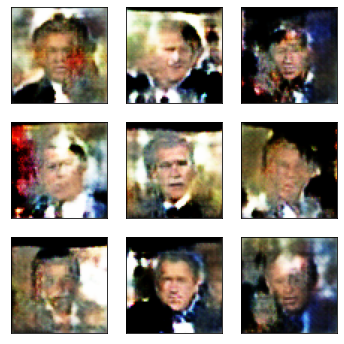

In [ ]:
checkpoint_file = 'checkpoints/wgan_final.pt'
if os.path.isfile(checkpoint_file):
    gen = torch.load(f'{checkpoint_file}', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=9, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

**Observations:**

The generated samples here already look significantly improved compared to the vanilla GAN. We can se distinct features on the face in both the top eye region and bottom mouth region. The face is the focal point of the image and where the image is least blurry. Here, there is still some blurriness in the background but in still better resolution compared to the vanilla GAN.

Sometimes, we can even see the top part of the suit. Since GW Bush is wearing a suit in all training images, we did expect to see this finding on the generated images at some point.

There are still blackout regions, that are randomly scattered throughout the image. It almost seems like the WGAN is generating the images from its connected components. Where some connected componenets are relatively clear and others are completely black. 

Clearly, using the Wassterstein loss improved the learning. Within the same amount of epochs we were able to achieve significantly better results. 

While the images are not perfect, we would say that GW Bush is recognizable from these generated images. 

In the WGAN, the losses attain different values compared to the vanilla GAN. The discriminator loss was at negative and the generator loss was around 0.6. The difference in values can be a result of using the Wasserstein function. 

#### SNGAN

*   **Generator** is the same as the vanilla GAN network.
*   **Discriminator** is composed of 4 convolusional layers, each followed by a batch norm then LeakyReLU layer. This is followed by a spectral norm layer, hence the SN-GAN. This is followed by a final convolution layer and then a sigmoid activation.
*   Both discriminator and generator used Adam optimizer

##### Training

In [3]:
#SNGAN
hp = sngan_hyperparams()
print(hp)
sngan_inc_score = SNGANTrainer(hp, dl_train).train(200)
#results = results.append(pd.DataFrame([['sngan', sngan_inc_score]], columns=['Model', 'Inception Score']))

##### Results

In [ ]:
print(f'''Inception score for final SNGAN model: 1.99 \n
Best hyperparameters: 
Batch size: {sngan_hyperparams()['batch_size']}
z_dim: {sngan_hyperparams()['z_dim']}
Discriminator optimizer learning rate: {sngan_hyperparams()['discriminator_optimizer']['lr']}
Discriminator optimizer betas: {sngan_hyperparams()['discriminator_optimizer']['betas']}
Generator optimizer learning rate: {sngan_hyperparams()['generator_optimizer']['lr']}
Generator optimizer betas: {sngan_hyperparams()['generator_optimizer']['betas']}
 ''')

Inception score for final SNGAN model: 1.99 

Best hyperparameters: 
Batch size: 36
z_dim: 10
Discriminator optimizer learning rate: 0.0002
Discriminator optimizer betas: (0.2, 0.999)
Generator optimizer learning rate: 0.0002
Generator optimizer betas: (0.1, 0.999)
 


*** Images Generated from best model:


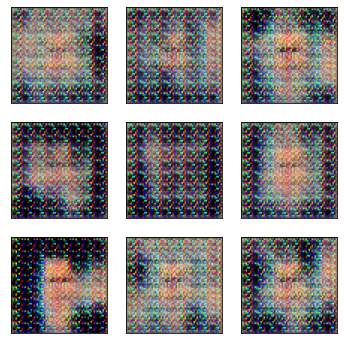

In [19]:
checkpoint_file = 'checkpoints/sngan_final.pt'
if os.path.isfile(checkpoint_file):
    gen = torch.load(f'{checkpoint_file}', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=9, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

**Observations:**

It is interesting to note that the inception score for this model was higher than the inception score of the vanilla GAN. 

However, the generated samples from this model did not appear as expected. We tried tuning the hypeparameters and playing with the model but we could not reach visually better results than the vanilla GAN.

The losses here were in the same range as the vanilla GAN. We did expect these values to be lower since we were using an improved version of the discriminator. 


#### W-SN-GAN

*   The spectral norm discriminator and vanilla generator was used to build the model
*  Wasserstein loss function was used for calculating loss


##### Training

In [4]:
hp = w_sn_gan_hyperparams()
print(hp)
wsngan = SNWGANTrainer(hp, dl_train).train(200)
results = results.append(pd.DataFrame([['SNWGAN', wsngan]], columns=['Model', 'Inception Score']))

##### Results

In [ ]:
print(f'''Inception score for final SN-W-GAN model: 3.01 \n
Best hyperparameters: 
Batch size: {w_sn_gan_hyperparams()['batch_size']}
z_dim: {w_sn_gan_hyperparams()['z_dim']}
SNDiscriminator optimizer learning rate: {w_sn_gan_hyperparams()['discriminator_optimizer']['lr']}
Generator optimizer learning rate: {w_sn_gan_hyperparams()['generator_optimizer']['lr']}
 ''')

Inception score for final SN-W-GAN model: 3.01 

Best hyperparameters: 
Batch size: 36
z_dim: 16
SNDiscriminator optimizer learning rate: 0.0002
Generator optimizer learning rate: 0.0002
 


*** Images Generated from best model:


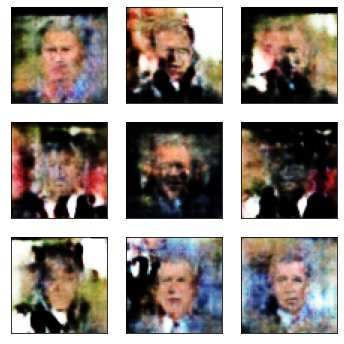

In [ ]:
checkpoint_file = 'checkpoints/snwgan_final.pt'
if os.path.isfile(checkpoint_file):
    gen = torch.load(f'{checkpoint_file}', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=9, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

**Observations:**

We expected to get clearer generated images with this final model. The images here resemble the results from the previous WGAN, without spectral norm. There is more blurriness in these images and more blackout regions randomly scattered. 

The inception score is also aligned with the quality of the generated images. The score is lower than the score for the WGAN. This is suprising, sice we expected the addition of both improvements to the GAN to be the best model so far. 

#### Analysis

In [21]:
results.to_csv('results.csv', index = False)

In [22]:
#Inception scores
results = pd.read_csv('results.csv')
results

,Model,Inception Score
0,GAN,1.40
1,WGAN,3.40
2,SNGAN,1.99
3,SNWGAN,3.01


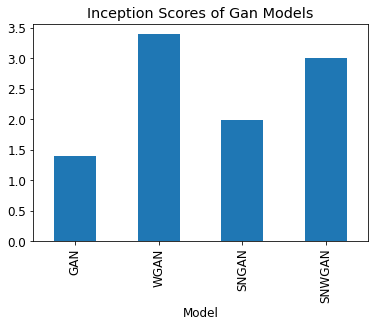

In [23]:
results.plot(y = 'Inception Score', x = 'Model', kind = 'bar', legend = False)
plt.title('Inception Scores of Gan Models')
plt.show()

Overall we found that the best generated images came from the WGAN model. This is aligned with the inception scores that were returned from each model. Spectral normalization made a small improvement on the score, but even less significant improvement on the generated images visually. 